In [2]:
using KomaMRI, MAT, Plots, LinearAlgebra

T1_ms, T2_ms = 2500, 800    # vial 1
#T1_ms, T2_ms = 1050, 140   # vial 6
T1, T2 = T1_ms / 1000, T2_ms / 1000

x_pos = collect(range(-10e-3, 10e-3, length=201))

obj = Phantom{Float64}(
    x = x_pos,
    y = zeros(length(x_pos)),
    z = zeros(length(x_pos)),
    T1 = fill(T1, length(x_pos)),
    T2 = fill(T2, length(x_pos)),
)

sys = Scanner()
sim_params = KomaMRICore.default_sim_params()
sim_params["return_type"] = "mat"
sim_params["sim_method"] = BlochDict()
sim_params["gpu"] = false

seq = read_seq("sequences/mpf_001_PhantomStudy_short_124.seq")

sig = simulate(obj, seq, sys; sim_params=sim_params)
sig_clean = dropdims(sig; dims=(3,4))

┌ Info: Loading sequence mpf_001_PhantomStudy_short_124.seq ...
└ @ KomaMRIFiles C:\Users\lucya\.julia\packages\KomaMRIFiles\Xc9Fh\src\Sequence\Pulseq.jl:339
┌ Info: Simulation will be run on the CPU with only 1 thread. To enable multi-threading, start julia with --threads=auto
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:335
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = BlochDict(save_Mz=false)
│   spins = 201
│   time_points = 42523
│   adc_points = 1000
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...   0%|█                             |  ETA: 1:58:42


Running simulation...  52%|████████████████              |  ETA: 0:00:08


Running simulation...  65%|████████████████████          |  ETA: 0:00:05


Running simulation...  76%|███████████████████████       |  ETA: 0:00:03


Running simulation...  86%|████████

  9.630938 seconds (21.41 M allocations: 1.559 GiB, 3.02% gc time, 90.06% compilation time: <1% of which was recompilation)


1000×201 Matrix{ComplexF32}:
  -0.0157605-0.016571im    …    0.0171454-0.0121412im
  0.00220857-0.0227564im       0.00196862-0.0208021im
   0.0190043-0.0137594im       -0.0147703-0.015512im
   0.0238353+0.00456267im      -0.0222808+0.000282965im
   0.0136913+0.0203848im       -0.0157865+0.0163748im
 -0.00464246+0.02355im     …  0.000297352+0.0223964im
  -0.0192205+0.0122277im        0.0154602+0.0146392im
  -0.0206311-0.00606189im       0.0198763-0.00168782im
 -0.00811336-0.0193726im        0.0108131-0.0158849im
   0.0101074-0.0191374im      -0.00573996-0.0187761im
            ⋮              ⋱             ⋮
  0.00154667+0.00261297im     -0.00154262+0.00260558im
  0.00188363+0.00249625im     -0.00188633+0.00248831im
  0.00216626+0.00266819im     -0.00217391+0.00266482im
  0.00219144+0.002996im       -0.00219907+0.00299933im
  0.00192938+0.00324042im  …   -0.0019321+0.00324823im
   0.0015449+0.00321723im     -0.00154102+0.00322448im
   0.0012542+0.00292719im     -0.00124631+0.00292923im
 

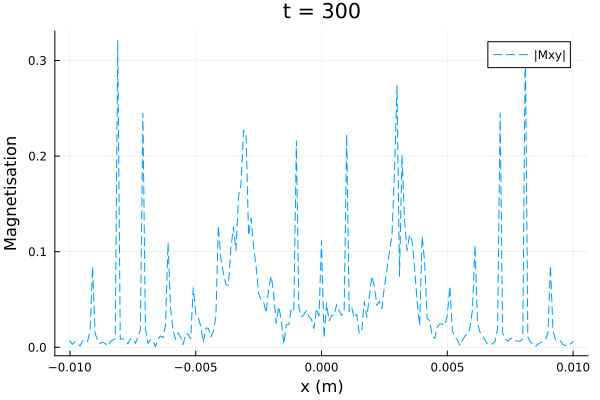

In [4]:
t_idx = 300

Mxy_t = sig_clean[t_idx, :]  # voxels' signals at t 

Mmag = abs.(Mxy_t)
Mphase = angle.(Mxy_t)
# Mx = real(Mxy_t)
# My = imag(Mxy_t)


plot(x_pos, Mmag, label="|Mxy|", linestyle=:dash, ylabel="Magnetisation", xlabel="x (m)", title="t = $(t_idx)")
#plot!(x_pos, Mphase, label="Phase(Mxy)", linestyle=:dot)


# ref_vector = sum(Mxy_t)
# ref_phase = angle(ref_vector)
# phase_diff = abs.(angle.(exp.(im .* (Mphase .- ref_phase))))  # angular distance from net phase
# threshold = 0.1 * maximum(Mmag)
# signal_mask = (Mmag .> threshold) .& (phase_diff .< π/4)
#scatter!(x_pos[signal_mask], Mmag[signal_mask],
         #label="Coherent contributors", color=:red, marker=:circle, ms=4)

In [7]:
slice_thickness = 10e-3  
inside_mask = abs.(x_pos) .<= (slice_thickness / 2)
outside_mask = .!inside_mask

S_total   = sum(Mxy_t)
S_inside  = sum(Mxy_t[inside_mask])
S_outside = sum(Mxy_t[outside_mask])


println("Complex signal:   ", S_total, "          mag: ", abs(S_total))
println("--> inside ±5mm:    ", S_inside, "         mag: ", abs(S_inside))
println("--> outside ±5mm:   ", S_outside, "       mag: ", abs(S_outside))


Complex signal:   0.39923936f0 - 0.99840844f0im          mag: 1.0752728
--> inside ±5mm:    0.3981443f0 - 0.66197103f0im         mag: 0.7724795
--> outside ±5mm:   0.0010949983f0 - 0.3364371f0im       mag: 0.3364389


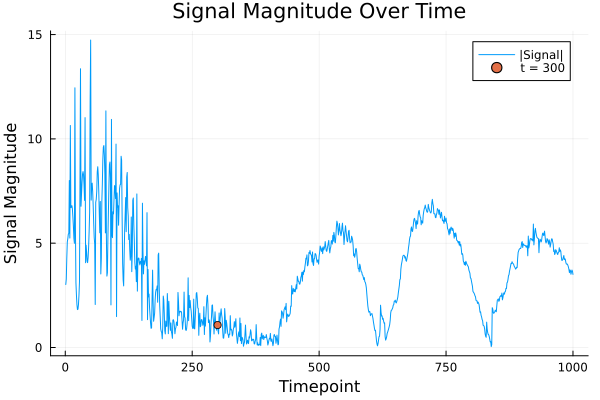

In [11]:
signal = vec(sum(sig_clean, dims=2))

plot(1:length(signal), abs.(signal),
     label="|Signal|",
     xlabel="Timepoint",
     ylabel="Signal Magnitude",
     title="Signal Magnitude Over Time")

scatter!([t_idx], [abs(signal[t_idx])],
         label="t = $t_idx")


In [ ]:
T2star = T2 * 0.3
T2prime = 1 / (1 / T2star - 1 / T2)
fwhm = 1 / (π * T2prime)  # Hz
γ = fwhm / 2

N_samples = 15
cutoff = 3 * γ
Δf_values = range(-cutoff, cutoff; length=N_samples) 

lorentz_pdf(f) = (γ / π) ./ (f.^2 .+ γ^2)
weights = lorentz_pdf.(Δf_values)
weights ./= sum(weights)

obj_t2star = Phantom{Float64}()
for (j, (Δf, w)) in enumerate(zip(Δf_values, weights))
    Δω = 2π * Δf 

    aux = Phantom{Float64}(
        x = x_pos,
        y = fill(j * 1e-6, length(x_pos)),
        z = zeros(length(x_pos)),
        T1 = fill(T1, length(x_pos)),
        T2 = fill(T2, length(x_pos)),
        Δw = fill(Δω, length(x_pos)),
        ρ = fill(w, length(x_pos))
    )

    obj_t2star += aux
end

sig = simulate(obj_t2star, seq, sys; sim_params=sim_params)
sig_clean = dropdims(sig; dims=(3,4))
signal_weighted = vec(sum(sig_clean, dims=2))

In [ ]:
data_reshaped = reshape(sig_clean, size(sig_clean, 1), 30, :)  
data_summed   = sum(data_reshaped, dims=2)          
data_summed   = dropdims(data_summed; dims=2) 

t_idx = 300
Mxy_t = data_summed[t_idx, :]

Mmag = abs.(Mxy_t)
Mphase = angle.(Mxy_t)
# Mx = real(Mxy_t)
# My = imag(Mxy_t)


plot(x_pos, Mmag, label="|Mxy|", linestyle=:dash, ylabel="Magnetisation", xlabel="x (m)", title="t = $(t_idx)")
#plot!(x_pos, Mphase, label="Phase(Mxy)", linestyle=:dot)